In [ ]:
!pip install transformers[torch] accelerate -U
!pip install datasets
!pip install vaderSentiment
!pip install scikit-learn
!pip install matplotlib
!pip install seaborn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 1.7 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.

Part 1: Import Libraries and Download Resources

In [ ]:
import pandas as pd
import time
import re
from transformers import pipeline, AutoTokenizer, BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from datasets import load_dataset, DatasetDict
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize  # Import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef, precision_recall_curve, auc, classification_report, confusion_matrix, roc_curve, roc_auc_score
from sklearn.preprocessing import LabelEncoder
import gensim.downloader as api
import numpy as np
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import LSTM, Dense, Masking
import matplotlib.pyplot as plt
import seaborn as sns
import random

# Download NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/9543 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2388 [00:00<?, ? examples/s]

Map:   0%|          | 0/9543 [00:00<?, ? examples/s]

Map:   0%|          | 0/2388 [00:00<?, ? examples/s]

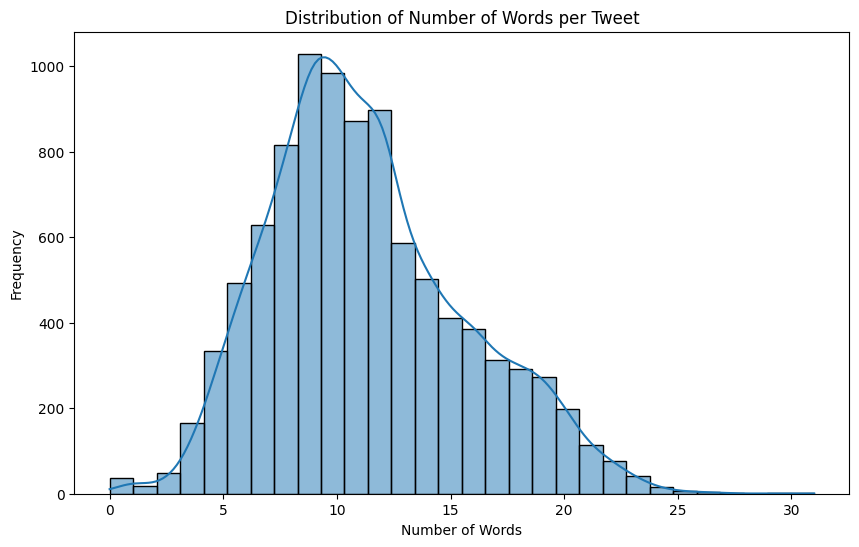

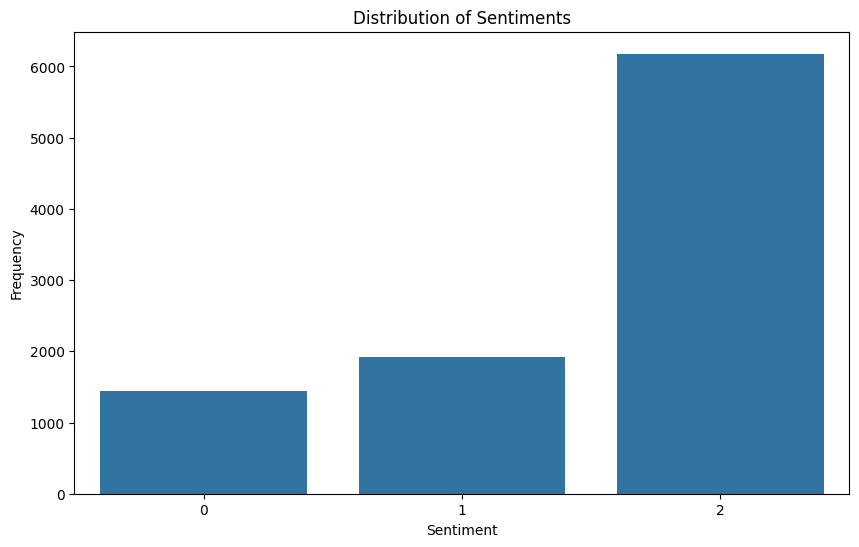

In [ ]:
# Load the dataset
dataset = load_dataset("zeroshot/twitter-financial-news-sentiment")

# Visualize the distribution of number of words per tweet
def preprocess_tweet(text):
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)  # Remove URLs
    text = re.sub(r'\@\w+|\#', '', text)  # Remove mentions and hashtags
    text = re.sub(r'[^A-Za-z0-9 ]+', '', text)  # Remove special characters
    return text

# Preprocess the tweets
dataset = dataset.map(lambda x: {"cleaned_tweet": preprocess_tweet(x["text"])})

# Visualize number of words per tweet
dataset_df = pd.DataFrame(dataset['train'])
dataset_df['word_count'] = dataset_df['cleaned_tweet'].apply(lambda x: len(x.split()))

plt.figure(figsize=(10, 6))
sns.histplot(dataset_df['word_count'], bins=30, kde=True)
plt.title('Distribution of Number of Words per Tweet')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()

# Check the distribution of sentiments
plt.figure(figsize=(10, 6))
sns.countplot(x=dataset_df['label'])
plt.title('Distribution of Sentiments')
plt.xlabel('Sentiment')
plt.ylabel('Frequency')
plt.show()

Part 3: Initialize the FinBERT Pipeline and Tokenizer

In [ ]:
# Initialize the FinBERT pipeline and tokenizer
pipe = pipeline("text-classification", model="ProsusAI/finbert")
tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")


config.json:   0%|          | 0.00/758 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Part 4: Define Stop Words, Part-of-Speech (POS) Tagging, Lemmatization, and Normalization Function

In [ ]:
# Get the list of stop words
stop_words = set(stopwords.words('english'))

# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()

# Function to preprocess text with lemmatization and normalization
def preprocess_text_with_lemmatization(text):
    text = text.lower()  # Normalize text to lowercase
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)  # Remove URLs
    text = re.sub(r'\@\w+|\#', '', text)  # Remove mentions and hashtags
    text = re.sub(r'[^A-Za-z0-9 ]+', '', text)  # Remove special characters
    words = text.split()
    words = [word for word in words if word not in stop_words]  # Remove stop words
    words = [lemmatizer.lemmatize(word) for word in words]  # Apply lemmatization
    return ' '.join(words)

# Function to classify sentiment with adjustable thresholds
def classify_tweet_with_thresholds(tweet, bearish_threshold=0.2, bullish_threshold=0.4):
    results = pipe(tweet)
    for result in results:
        label = result['label']
        score = result['score']
        print(f"Debug: Label = {label}, Score = {score}")  # Debugging statement

    # Use the highest scoring label
    top_result = results[0]
    label = top_result['label']
    score = top_result['score']

    # Check thresholds
    if label == 'negative':
        if score >= bearish_threshold:
            return 'Bearish'
    elif label == 'positive':
        if score >= bullish_threshold:
            return 'Bullish'
    return 'Neutral'

Part 3: Analyze Sentiment with Thresholds

In [ ]:
# Function to analyze sentiment with thresholds
def analyze_sentiment_with_thresholds(example):
    preprocessed_text = preprocess_text_with_lemmatization(example["text"])
    sentiment = classify_tweet_with_thresholds(preprocessed_text)
    example["predicted_sentiment"] = sentiment
    return example

Part 4: Prepare Dataset

In [ ]:
# Define the number of samples you want to keep
num_samples = 3000

# Function to get a random subset of the dataset
def get_random_subset(dataset, num_samples):
    import random
    indices = list(range(len(dataset)))
    random.shuffle(indices)
    selected_indices = indices[:num_samples]
    return dataset.select(selected_indices)

# Split the dataset into train and test
dataset = dataset['train'].train_test_split(test_size=0.2, seed=42)

# Get random subsets for train and test
train_subset = get_random_subset(dataset['train'], num_samples)
test_subset = get_random_subset(dataset['test'], int(num_samples * 0.2))

# Create a DatasetDict with the subsets
dataset_dict_subset = DatasetDict({
    'train': train_subset,
    'test': test_subset
})


Part 5: Apply Sentiment Analysis

In [ ]:
# Start timing for the sentiment analysis step
start_time = time.time()

# Apply the updated function to the dataset with thresholds
dataset_lemmatized_with_thresholds_subset = dataset_dict_subset.map(analyze_sentiment_with_thresholds)

# End timing for the sentiment analysis step
end_time = time.time()
print(f"Time taken for sentiment analysis: {end_time - start_time} seconds")

# Display some results
print(dataset_lemmatized_with_thresholds_subset["train"][0])


Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

Debug: Label = positive, Score = 0.5427072048187256
Debug: Label = neutral, Score = 0.7898117303848267
Debug: Label = neutral, Score = 0.9480288028717041
Debug: Label = neutral, Score = 0.9094675779342651
Debug: Label = neutral, Score = 0.6909294128417969
Debug: Label = negative, Score = 0.5823858380317688
Debug: Label = positive, Score = 0.8286372423171997
Debug: Label = negative, Score = 0.9153590202331543
Debug: Label = neutral, Score = 0.9467052221298218
Debug: Label = neutral, Score = 0.8823029398918152
Debug: Label = neutral, Score = 0.9427343010902405
Debug: Label = negative, Score = 0.9682960510253906
Debug: Label = neutral, Score = 0.7547547221183777
Debug: Label = positive, Score = 0.6031789183616638
Debug: Label = neutral, Score = 0.8348649740219116
Debug: Label = neutral, Score = 0.9352824091911316
Debug: Label = positive, Score = 0.9181102514266968
Debug: Label = positive, Score = 0.7261890172958374
Debug: Label = neutral, Score = 0.7398418188095093
Debug: Label = neutral,

Map:   0%|          | 0/600 [00:00<?, ? examples/s]

Debug: Label = negative, Score = 0.824094831943512
Debug: Label = neutral, Score = 0.8982331156730652
Debug: Label = neutral, Score = 0.938285231590271
Debug: Label = neutral, Score = 0.9328298568725586
Debug: Label = neutral, Score = 0.7458428144454956
Debug: Label = neutral, Score = 0.835456907749176
Debug: Label = neutral, Score = 0.8867228031158447
Debug: Label = negative, Score = 0.8533505201339722
Debug: Label = neutral, Score = 0.8844082951545715
Debug: Label = neutral, Score = 0.7929770350456238
Debug: Label = neutral, Score = 0.6771200299263
Debug: Label = negative, Score = 0.48811057209968567
Debug: Label = neutral, Score = 0.8992065787315369
Debug: Label = negative, Score = 0.5930356383323669
Debug: Label = negative, Score = 0.613980770111084
Debug: Label = neutral, Score = 0.9396851658821106
Debug: Label = neutral, Score = 0.9331439137458801
Debug: Label = neutral, Score = 0.8578883409500122
Debug: Label = neutral, Score = 0.8417812585830688
Debug: Label = neutral, Score = 

In [ ]:
# Check the distribution of predicted sentiments
predicted_sentiments = dataset_lemmatized_with_thresholds_subset["train"]["predicted_sentiment"]
unique_sentiments, sentiment_counts = np.unique(predicted_sentiments, return_counts=True)
print(f"Predicted sentiment distribution: {dict(zip(unique_sentiments, sentiment_counts))}")


Predicted sentiment distribution: {'Bearish': 555, 'Bullish': 338, 'Neutral': 2107}


In [ ]:


# Check the distribution of predicted sentiments
predicted_sentiments = dataset_lemmatized_with_thresholds_subset["train"]["predicted_sentiment"]
unique_sentiments, sentiment_counts = np.unique(predicted_sentiments, return_counts=True)
print(f"Predicted sentiment distribution: {dict(zip(unique_sentiments, sentiment_counts))}")

# Calculate percentage of each sentiment
total_count = np.sum(sentiment_counts)
percentage_distribution = {sentiment: (count / total_count) * 100 for sentiment, count in zip(unique_sentiments, sentiment_counts)}

# Print the percentage distribution
print(f"Percentage distribution: {percentage_distribution}")


Predicted sentiment distribution: {'Bearish': 555, 'Bullish': 338, 'Neutral': 2107}
Percentage distribution: {'Bearish': 18.5, 'Bullish': 11.266666666666666, 'Neutral': 70.23333333333333}


In [ ]:
# Extract text and labels from the dataset
df_train = pd.DataFrame(dataset_lemmatized_with_thresholds_subset["train"])
corpus = df_train["text"]
labels = df_train["predicted_sentiment"]

# Encode labels to numerical values
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(labels)

# Check the class distribution before splitting
unique_classes, class_counts = np.unique(y, return_counts=True)
print(f"Class distribution before splitting: {dict(zip(unique_classes, class_counts))}")

Class distribution before splitting: {0: 555, 1: 338, 2: 2107}


In [ ]:
# Initialize the TF-IDF vectorizer
vectorizer = TfidfVectorizer()
X_tfidf = vectorizer.fit_transform(corpus)

# Split the data into training and testing sets using stratified split
train_indices, test_indices, y_train, y_test = train_test_split(df_train.index, y, test_size=0.2, random_state=42, stratify=y)
X_train = X_tfidf[train_indices]
X_test = X_tfidf[test_indices]

# Check the distribution of classes in y_train and y_test
print("Training set class distribution:", np.bincount(y_train))
print("Test set class distribution:", np.bincount(y_test))

Training set class distribution: [ 444  270 1686]
Test set class distribution: [111  68 421]


Part 7: Example Tweet Classification

In [ ]:
# Example tweet to classify
tweet = "The company's lack of innovation will lead to stagnation and declining market share.."

# Preprocess the tweet
preprocessed_tweet = preprocess_text_with_lemmatization(tweet)

# Classify the tweet
sentiment = classify_tweet_with_thresholds(preprocessed_tweet)

# Display the classification result
print(f'The tweet is classified as: {sentiment}')


Debug: Label = negative, Score = 0.9650284051895142
The tweet is classified as: Bearish


SVM WITH TF-IDF

In [ ]:
# Train and evaluate SVM with TF-IDF
svm_model_tfidf = SVC(probability=True)
svm_model_tfidf.fit(X_train, y_train)

# Make predictions
y_pred_svm_tfidf = svm_model_tfidf.predict(X_test)

In [ ]:
# Evaluate SVM Model with TF-IDF
accuracy_svm_tfidf = accuracy_score(y_test, y_pred_svm_tfidf)
precision_svm_tfidf = precision_score(y_test, y_pred_svm_tfidf, average='macro')
recall_svm_tfidf = recall_score(y_test, y_pred_svm_tfidf, average='macro')
f1_svm_tfidf = f1_score(y_test, y_pred_svm_tfidf, average='macro')
mcc_svm_tfidf = matthews_corrcoef(y_test, y_pred_svm_tfidf)

print(f'''SVM with TF-IDF -
Accuracy: {accuracy_svm_tfidf},
Precision: {precision_svm_tfidf},
Recall: {recall_svm_tfidf},
F1 Score: {f1_svm_tfidf},
MCC: {mcc_svm_tfidf}''')

SVM with TF-IDF -
Accuracy: 0.7066666666666667,
Precision: 0.769023569023569,
Recall: 0.3464525374892847,
F1 Score: 0.30276528402465436,
MCC: 0.10763532889252649


In [ ]:
# Load GloVe pre-trained vectors
glove_vectors = api.load("glove-wiki-gigaword-100")

def get_glove_embeddings(text):
    words = text.split()
    embeddings = [glove_vectors[word] for word in words if word in glove_vectors]
    return embeddings

glove_embeddings = [get_glove_embeddings(text) for text in corpus]

def aggregate_embeddings(embeddings):
    if embeddings:
        return np.mean(embeddings, axis=0)  # Averaging embeddings
    else:
        return np.zeros(100)  # Assuming GloVe vector size is 100

X_glove = np.array([aggregate_embeddings(embedding) for embedding in glove_embeddings])


In [ ]:
# Split the data into training and testing sets
X_train_glove, X_test_glove, y_train_glove, y_test_glove = train_test_split(X_glove, y, test_size=0.2, random_state=42)


Evaluate SVM Model with GloVe

In [ ]:
# Train and evaluate SVM with GloVe
svm_model_glove = SVC(probability=True)
svm_model_glove.fit(X_train_glove, y_train_glove)

# Make predictions
y_pred_svm_glove = svm_model_glove.predict(X_test_glove)

# Evaluate SVM Model with GloVe
accuracy_svm_glove = accuracy_score(y_test_glove, y_pred_svm_glove)
precision_svm_glove = precision_score(y_test_glove, y_pred_svm_glove, average='macro')
recall_svm_glove = recall_score(y_test_glove, y_pred_svm_glove, average='macro')
f1_svm_glove = f1_score(y_test_glove, y_pred_svm_glove, average='macro')
mcc_svm_glove = matthews_corrcoef(y_test_glove, y_pred_svm_glove)

print(f'''SVM with GloVe -
Accuracy: {accuracy_svm_glove},
Precision: {precision_svm_glove},
Recall: {recall_svm_glove},
F1 Score: {f1_svm_glove},
MCC: {mcc_svm_glove}''')

SVM with GloVe -
Accuracy: 0.7433333333333333,
Precision: 0.45429556263362275,
Recall: 0.40064604149111194,
F1 Score: 0.3904260104093042,
MCC: 0.2866400359986444


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Hyperparameter Tuning and Evaluation

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef, precision_recall_curve, auc
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for GridSearchCV
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001],
    'kernel': ['rbf', 'linear']
}

# Initialize GridSearchCV with SVM model and parameter grid
grid_search = GridSearchCV(SVC(class_weight='balanced', probability=True), param_grid, refit=True, verbose=2, cv=3)

# Perform the grid search
grid_search.fit(X_train, y_train)

# Get the best parameters
print(f'Best Parameters: {grid_search.best_params_}')

# Make predictions with the best model
y_pred_svm_tuned = grid_search.best_estimator_.predict(X_test)
y_pred_proba_svm_tuned = grid_search.best_estimator_.predict_proba(X_test)  # Get the predicted probabilities

# Evaluate the best SVM model
accuracy_svm_tuned = accuracy_score(y_test, y_pred_svm_tuned)
precision_svm_tuned = precision_score(y_test, y_pred_svm_tuned, average='macro')
recall_svm_tuned = recall_score(y_test, y_pred_svm_tuned, average='macro')
f1_svm_tuned = f1_score(y_test, y_pred_svm_tuned, average='macro')
mcc_svm_tuned = matthews_corrcoef(y_test, y_pred_svm_tuned)

print(f'Tuned SVM - Accuracy: {accuracy_svm_tuned}, Precision: {precision_svm_tuned}, Recall: {recall_svm_tuned}, F1 Score: {f1_svm_tuned}, MCC: {mcc_svm_tuned}')

# Compute Precision-Recall AUC for each class
precision_vals, recall_vals, _ = precision_recall_curve(y_test, y_pred_proba_svm_tuned[:, 1], pos_label=1)  # For class 1
pr_auc_svm_tuned = auc(recall_vals, precision_vals)

print(f'Tuned SVM - Precision-Recall AUC: {pr_auc_svm_tuned}')


Fitting 3 folds for each of 32 candidates, totalling 96 fits
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   6.3s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   4.5s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   5.4s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   4.1s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   3.0s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   3.0s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   3.9s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   3.7s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   3.3s
[CV] END ....................C=0.1, gamma=0.1, kernel=linear; total time=   3.0s
[CV] END ....................C=0.1, gamma=0.1, kernel=linear; total time=   3.3s
[CV] END ....................C=0.1, gamma=0.1, k

In [ ]:
param_grid = {
    'C': [0.1, 1, 10, 100, 1000],
    'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
    'kernel': ['rbf', 'linear']
}

# Initialize GridSearchCV with SVM model and parameter grid
grid_search = GridSearchCV(SVC(class_weight='balanced', probability=True), param_grid, refit=True, verbose=2, cv=5)

# Perform the grid search
grid_search.fit(X_train, y_train)

# Get the best parameters
print(f'Best Parameters: {grid_search.best_params_}')

# Make predictions with the best model
y_pred_svm_tuned = grid_search.best_estimator_.predict(X_test)
y_pred_proba_svm_tuned = grid_search.best_estimator_.predict_proba(X_test)  # Get the predicted probabilities

# Evaluate the best SVM model
accuracy_svm_tuned = accuracy_score(y_test, y_pred_svm_tuned)
precision_svm_tuned = precision_score(y_test, y_pred_svm_tuned, average='macro')
recall_svm_tuned = recall_score(y_test, y_pred_svm_tuned, average='macro')
f1_svm_tuned = f1_score(y_test, y_pred_svm_tuned, average='macro')
mcc_svm_tuned = matthews_corrcoef(y_test, y_pred_svm_tuned)

print(f'Tuned SVM - Accuracy: {accuracy_svm_tuned}, Precision: {precision_svm_tuned}, Recall: {recall_svm_tuned}, F1 Score: {f1_svm_tuned}, MCC: {mcc_svm_tuned}')

# Compute Precision-Recall AUC for each class
precision_vals, recall_vals, _ = precision_recall_curve(y_test, y_pred_proba_svm_tuned[:, 1], pos_label=1)  # For class 1
pr_auc_svm_tuned = auc(recall_vals, precision_vals)

print(f'Tuned SVM - Precision-Recall AUC: {pr_auc_svm_tuned}')


Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   6.4s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=  10.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   5.1s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   5.7s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   4.7s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   4.3s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   5.1s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   4.2s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   4.2s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   5.2s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   4.6s
[CV] END .......................C=0.1, gamma=0.

In [ ]:
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for LightGBM
param_grid_lgb = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'num_leaves': [31, 63, 127],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# Initialize GridSearchCV with LightGBM model and parameter grid
grid_search_lgb = GridSearchCV(lgb.LGBMClassifier(), param_grid_lgb, refit=True, verbose=2, cv=3)

# Perform the grid search
grid_search_lgb.fit(X_train, y_train)

# Get the best parameters
print(f'Best Parameters for LightGBM: {grid_search_lgb.best_params_}')

# Make predictions with the best model
y_pred_lgb_tuned = grid_search_lgb.best_estimator_.predict(X_test)
y_pred_proba_lgb_tuned = grid_search_lgb.best_estimator_.predict_proba(X_test)  # Get the predicted probabilities

# Evaluate the best LightGBM model
accuracy_lgb_tuned = accuracy_score(y_test, y_pred_lgb_tuned)
precision_lgb_tuned = precision_score(y_test, y_pred_lgb_tuned, average='macro')
recall_lgb_tuned = recall_score(y_test, y_pred_lgb_tuned, average='macro')
f1_lgb_tuned = f1_score(y_test, y_pred_lgb_tuned, average='macro')
mcc_lgb_tuned = matthews_corrcoef(y_test, y_pred_lgb_tuned)

print(f'Tuned LightGBM - Accuracy: {accuracy_lgb_tuned}, Precision: {precision_lgb_tuned}, Recall: {recall_lgb_tuned}, F1 Score: {f1_lgb_tuned}, MCC: {mcc_lgb_tuned}')

# Compute Precision-Recall AUC for each class
precision_vals, recall_vals, _ = precision_recall_curve(y_test, y_pred_proba_lgb_tuned[:, 1], pos_label=1)  # For class 1
pr_auc_lgb_tuned = auc(recall_vals, precision_vals)

print(f'Tuned LightGBM - Precision-Recall AUC: {pr_auc_lgb_tuned}')


/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


Streaming output truncated to the last 5000 lines.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

In [ ]:
from sklearn.ensemble import StackingClassifier

# Define the base models with their best estimators
estimators = [
    ('svm', grid_search.best_estimator_),
    ('lgb', grid_search_lgb.best_estimator_)
]

# Initialize StackingClassifier with a final estimator (meta-model), for example, a logistic regression classifier
from sklearn.linear_model import LogisticRegression
final_estimator = LogisticRegression()

stacking_clf = StackingClassifier(estimators=estimators, final_estimator=final_estimator, cv=5)

# Fit the stacking model
stacking_clf.fit(X_train, y_train)

# Make predictions with the stacking model
y_pred_stack = stacking_clf.predict(X_test)
y_pred_proba_stack = stacking_clf.predict_proba(X_test)

# Evaluate the stacking model
accuracy_stack = accuracy_score(y_test, y_pred_stack)
precision_stack = precision_score(y_test, y_pred_stack, average='macro')
recall_stack = recall_score(y_test, y_pred_stack, average='macro')
f1_stack = f1_score(y_test, y_pred_stack, average='macro')
mcc_stack = matthews_corrcoef(y_test, y_pred_stack)

print(f'Stacking Model - Accuracy: {accuracy_stack}, Precision: {precision_stack}, Recall: {recall_stack}, F1 Score: {f1_stack}, MCC: {mcc_stack}')

# Compute Precision-Recall AUC for each class
precision_vals, recall_vals, _ = precision_recall_curve(y_test, y_pred_proba_stack[:, 1], pos_label=1)  # For class 1
pr_auc_stack = auc(recall_vals, precision_vals)

print(f'Stacking Model - Precision-Recall AUC: {pr_auc_stack}')


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005211 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4301
[LightGBM] [Info] Number of data points in the train set: 2400, number of used features: 179
[LightGBM] [Info] Start training from score -1.750138
[LightGBM] [Info] Start training from score -2.144869
[LightGBM] [Info] Start training from score -0.343665
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spl

Visualize Performance Metrics (ROC Curves)
Generate ROC curves for the models trained with TF-IDF and GloVe, and the hyperparameter-tuned SVM.

ROC Curves for SVM with TF-IDF

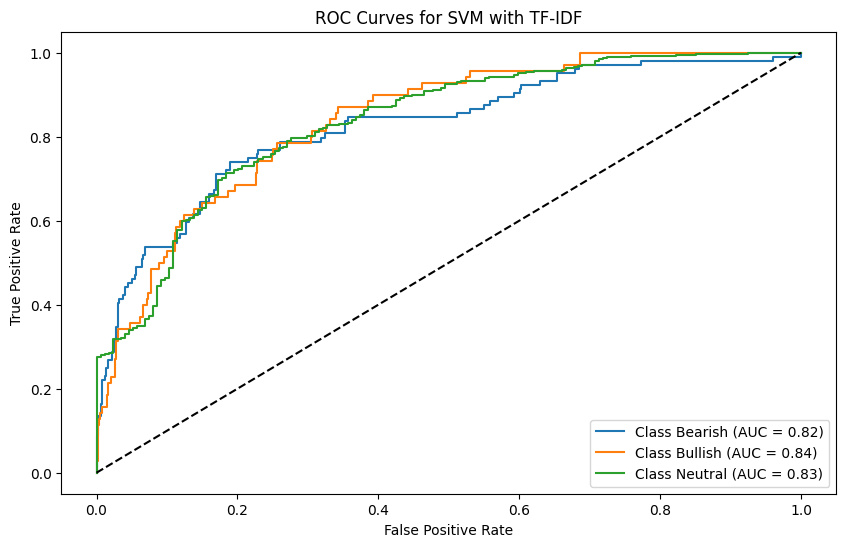

In [ ]:
# Calculate ROC curve and AUC for SVM with TF-IDF
y_probs_tfidf = svm_model_tfidf.predict_proba(X_test)
fpr_tfidf = {}
tpr_tfidf = {}
roc_auc_tfidf = {}

for i in range(len(label_encoder.classes_)):
    fpr_tfidf[i], tpr_tfidf[i], _ = roc_curve(y_test == i, y_probs_tfidf[:, i])
    roc_auc_tfidf[i] = auc(fpr_tfidf[i], tpr_tfidf[i])

# Plot ROC curves for SVM with TF-IDF
plt.figure(figsize=(10, 6))
for i in range(len(label_encoder.classes_)):
    plt.plot(fpr_tfidf[i], tpr_tfidf[i], label=f'Class {label_encoder.classes_[i]} (AUC = {roc_auc_tfidf[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for SVM with TF-IDF')
plt.legend(loc='lower right')
plt.show()


ROC Curves for SVM with GloVe

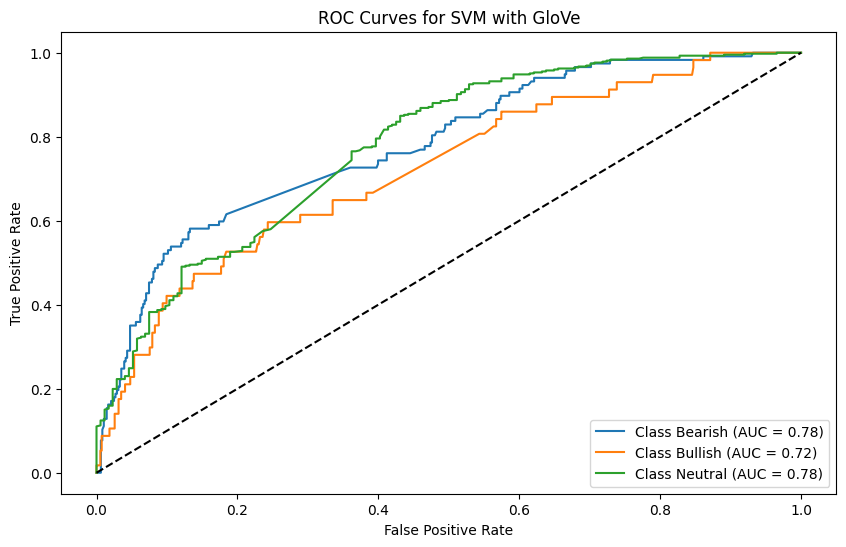

In [ ]:
# Calculate ROC curve and AUC for SVM with GloVe
y_probs_glove = svm_model_glove.predict_proba(X_test_glove)
fpr_glove = {}
tpr_glove = {}
roc_auc_glove = {}

for i in range(len(label_encoder.classes_)):
    fpr_glove[i], tpr_glove[i], _ = roc_curve(y_test_glove == i, y_probs_glove[:, i])
    roc_auc_glove[i] = auc(fpr_glove[i], tpr_glove[i])

# Plot ROC curves for SVM with GloVe
plt.figure(figsize=(10, 6))
for i in range(len(label_encoder.classes_)):
    plt.plot(fpr_glove[i], tpr_glove[i], label=f'Class {label_encoder.classes_[i]} (AUC = {roc_auc_glove[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for SVM with GloVe')
plt.legend(loc='lower right')
plt.show()


ROC Curves for Tuned SVM

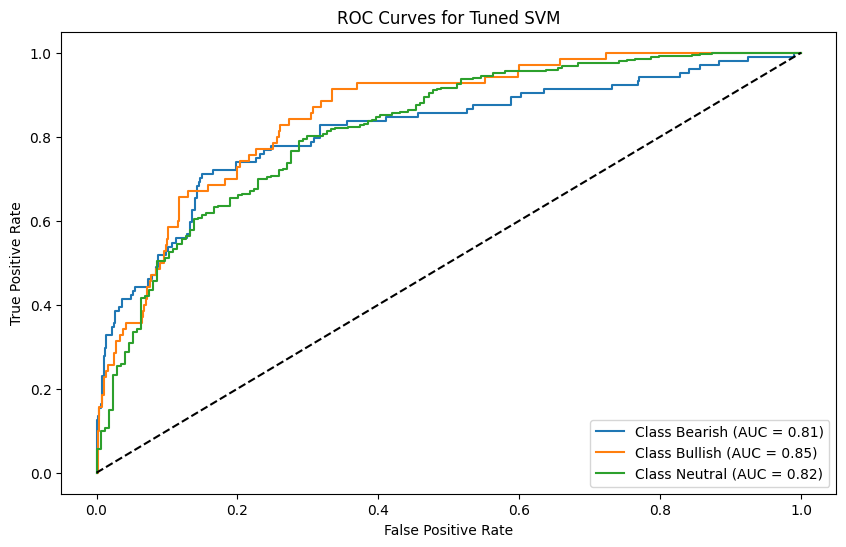

In [ ]:
# Calculate ROC curve and AUC for Tuned SVM
y_probs_tuned = grid_search.best_estimator_.predict_proba(X_test)
fpr_tuned = {}
tpr_tuned = {}
roc_auc_tuned = {}

for i in range(len(label_encoder.classes_)):
    fpr_tuned[i], tpr_tuned[i], _ = roc_curve(y_test == i, y_probs_tuned[:, i])
    roc_auc_tuned[i] = auc(fpr_tuned[i], tpr_tuned[i])

# Plot ROC curves for Tuned SVM
plt.figure(figsize=(10, 6))
for i in range(len(label_encoder.classes_)):
    plt.plot(fpr_tuned[i], tpr_tuned[i], label=f'Class {label_encoder.classes_[i]} (AUC = {roc_auc_tuned[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Tuned SVM')
plt.legend(loc='lower right')
plt.show()


Compare All SVM Models
Create a bar chart to compare the performance of all SVM models (with TF-IDF, GloVe, and hyperparameter-tuned SVM).

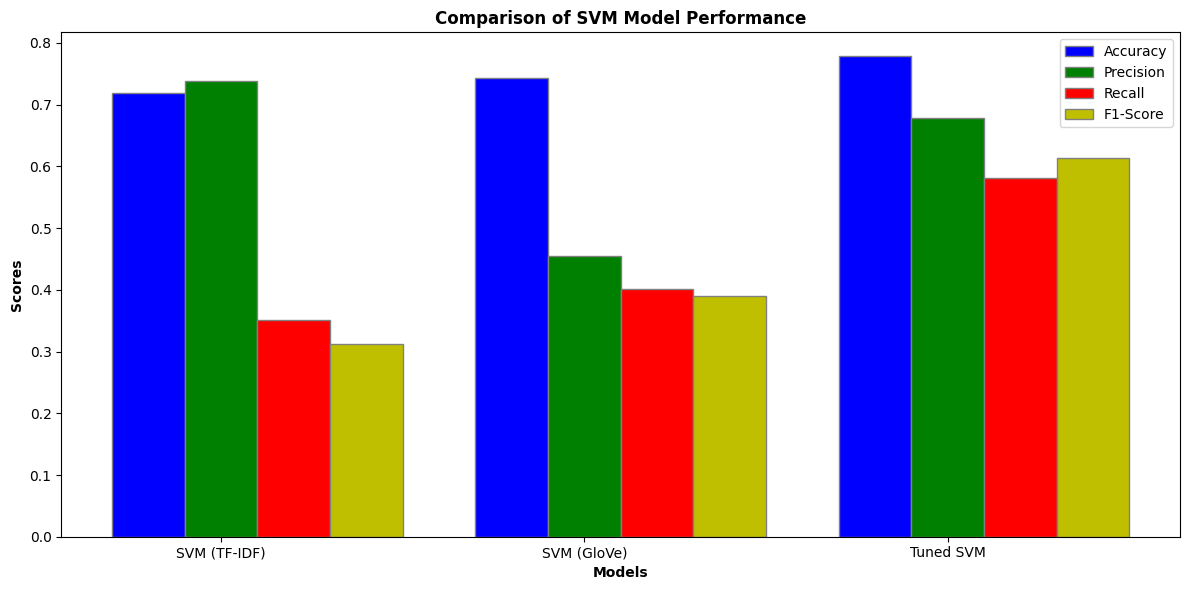

In [ ]:
# Data for the bar chart
models = ['SVM (TF-IDF)', 'SVM (GloVe)', 'Tuned SVM']
accuracy_scores = [accuracy_svm_tfidf, accuracy_svm_glove, accuracy_svm_tuned]
precision_scores = [precision_svm_tfidf, precision_svm_glove, precision_svm_tuned]
recall_scores = [recall_svm_tfidf, recall_svm_glove, recall_svm_tuned]
f1_scores = [f1_svm_tfidf, f1_svm_glove, f1_svm_tuned]

# Set the width of the bars
bar_width = 0.2

# Set the positions of the bars on the x-axis
r1 = np.arange(len(accuracy_scores))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]
r4 = [x + bar_width for x in r3]

# Create the bar chart
plt.figure(figsize=(12, 6))

plt.bar(r1, accuracy_scores, color='b', width=bar_width, edgecolor='grey', label='Accuracy')
plt.bar(r2, precision_scores, color='g', width=bar_width, edgecolor='grey', label='Precision')
plt.bar(r3, recall_scores, color='r', width=bar_width, edgecolor='grey', label='Recall')
plt.bar(r4, f1_scores, color='y', width=bar_width, edgecolor='grey', label='F1-Score')

# Add labels, title, and legend
plt.xlabel('Models', fontweight='bold')
plt.ylabel('Scores', fontweight='bold')
plt.xticks([r + bar_width for r in range(len(accuracy_scores))], models)
plt.title('Comparison of SVM Model Performance', fontweight='bold')
plt.legend()

# Display the chart
plt.tight_layout()
plt.show()


Preprocessing and FinBERT Integration

In [ ]:
# Start timing for converting to DatasetDict and preprocessing
start_time = time.time()

def preprocess_text_for_bert(examples):
    return tokenizer(examples['text'], padding='max_length', truncation=True, max_length=64)

# Apply the preprocessing
dataset_dict_subset = dataset_lemmatized_with_thresholds_subset.map(preprocess_text_for_bert, batched=True)
dataset_dict_subset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

# End timing for converting and preprocessing
end_time = time.time()
print(f"Time taken for converting and preprocessing: {end_time - start_time} seconds")

# Extract text from the dataset
corpus = dataset_lemmatized_with_thresholds_subset["train"]["text"]

# Initialize the TF-IDF vectorizer
vectorizer = TfidfVectorizer()
X_tfidf = vectorizer.fit_transform(corpus)

# Display TF-IDF matrix
print(X_tfidf.toarray())
print(vectorizer.get_feature_names_out())

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

Map:   0%|          | 0/600 [00:00<?, ? examples/s]

Time taken for converting and preprocessing: 0.8785183429718018 seconds
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
['00' '000' '00pm' ... 'échelle' 'öltözik' 'übernahme']


FinBERT Model Training and Evaluation



In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef, precision_recall_curve, auc
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, DataCollatorWithPadding

# Initialize the FinBERT tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert", num_labels=3)

# Preprocess the dataset for FinBERT
def preprocess_text_for_finbert(examples):
    encoding = tokenizer(examples['text'], padding='max_length', truncation=True, max_length=64)
    return encoding

# Assuming `dataset` is already loaded
dataset = dataset.map(preprocess_text_for_finbert, batched=True)

# Subsample the dataset to reduce the size
small_train_dataset = dataset['train'].shuffle(seed=42).select([i for i in list(range(0, 500))])
small_test_dataset = dataset['train'].shuffle(seed=42).select([i for i in list(range(500, 600))])

# Split the dataset into train and test
dataset_lemmatized = DatasetDict({'train': small_train_dataset, 'test': small_test_dataset})

# Set the format for PyTorch
dataset_lemmatized['train'].set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
dataset_lemmatized['test'].set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

# Data collator
data_collator = DataCollatorWithPadding(tokenizer)

# Define metrics
def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    precision = precision_score(p.label_ids, preds, average='macro')
    recall = recall_score(p.label_ids, preds, average='macro')
    f1 = f1_score(p.label_ids, preds, average='macro')
    mcc = matthews_corrcoef(p.label_ids, preds)
    precision_vals, recall_vals, _ = precision_recall_curve(p.label_ids, preds, pos_label=1)
    pr_auc = auc(recall_vals, precision_vals)
    return {
        'accuracy': accuracy_score(p.label_ids, preds),
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'mcc': mcc,
        'pr_auc': pr_auc
    }

# Training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=1,  # Reduce the number of epochs for quick training
    per_device_train_batch_size=4,  # Reduce the batch size for compatibility
    per_device_eval_batch_size=4,  # Reduce the batch size for compatibility
    warmup_steps=200,  # Reduce warmup steps for quick training
    weight_decay=0.01,
    logging_dir='./logs',
)

# Initialize Trainer
trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=dataset_lemmatized['train'],         # training dataset
    eval_dataset=dataset_lemmatized['test'],           # evaluation dataset
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics       # Function to compute metrics
)

# Train the FinBERT model
trainer.train()

# Evaluate the FinBERT model
results = trainer.evaluate()

# Extract necessary metrics from results
accuracy_bert = results['eval_accuracy']
precision_bert = results['eval_precision']
recall_bert = results['eval_recall']
f1_bert = results['eval_f1']
mcc_bert = results['eval_mcc']
pr_auc_bert = results['eval_pr_auc']

# Display FinBERT metrics
print(f'FinBERT Accuracy: {accuracy_bert}')
print(f'FinBERT Precision (Macro): {precision_bert}')
print(f'FinBERT Recall (Macro): {recall_bert}')
print(f'FinBERT F1 Score (Macro): {f1_bert}')
print(f'FinBERT Matthews Correlation Coefficient: {mcc_bert}')
print(f'FinBERT Precision-Recall AUC: {pr_auc_bert}')



Map:   0%|          | 0/7634 [00:00<?, ? examples/s]

Map:   0%|          | 0/1909 [00:00<?, ? examples/s]

Step,Training Loss


FinBERT Accuracy: 0.71
FinBERT Precision (Macro): 0.5283128636069813
FinBERT Recall (Macro): 0.500980500980501
FinBERT F1 Score (Macro): 0.5063336636164054
FinBERT Matthews Correlation Coefficient: 0.42705388093880614
FinBERT Precision-Recall AUC: 0.326451938865732


Hybrid Model (SVM + FinBERT)

FinBERT HERE

In [ ]:
from transformers import pipeline, AutoTokenizer

# Initialize the FinBERT pipeline and tokenizer
pipe = pipeline("text-classification", model="ProsusAI/finbert")
tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")


In [ ]:
def preprocess_text_for_finbert(examples):
    encoding = tokenizer(examples['text'], padding='max_length', truncation=True, max_length=64)
    return encoding

dataset = dataset.map(preprocess_text_for_finbert, batched=True)


Map:   0%|          | 0/7634 [00:00<?, ? examples/s]

Map:   0%|          | 0/1909 [00:00<?, ? examples/s]

In [ ]:
small_train_dataset = dataset['train'].shuffle(seed=42).select([i for i in list(range(0, 500))])
small_test_dataset = dataset['train'].shuffle(seed=42).select([i for i in list(range(500, 600))])

dataset_lemmatized = {'train': small_train_dataset, 'test': small_test_dataset}

dataset_lemmatized['train'].set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
dataset_lemmatized['test'].set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])


In [ ]:
# Example texts for prediction
texts = ["The market is looking bullish today.", "There is a lot of uncertainty in the market."]

# Use the pipeline for predictions
predictions = pipe(texts)

# Display predictions
for text, pred in zip(texts, predictions):
    print(f"Text: {text}")
    print(f"Prediction: {pred}")


Text: The market is looking bullish today.
Prediction: {'label': 'positive', 'score': 0.7777194976806641}
Text: There is a lot of uncertainty in the market.
Prediction: {'label': 'negative', 'score': 0.7077950239181519}


FinBERT

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef, precision_recall_curve, auc
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, DataCollatorWithPadding

# Initialize the FinBERT tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert", num_labels=3)

# Preprocess the dataset for FinBERT
def preprocess_text_for_finbert(examples):
    encoding = tokenizer(examples['text'], padding='max_length', truncation=True, max_length=64)
    return encoding

# Assuming `dataset` is already loaded
dataset = dataset.map(preprocess_text_for_finbert, batched=True)

# Subsample the dataset to reduce the size
small_train_dataset = dataset['train'].shuffle(seed=42).select([i for i in list(range(0, 500))])
small_test_dataset = dataset['train'].shuffle(seed=42).select([i for i in list(range(500, 600))])

# Split the dataset into train and test
dataset_lemmatized = {'train': small_train_dataset, 'test': small_test_dataset}

# Set the format for PyTorch
dataset_lemmatized['train'].set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
dataset_lemmatized['test'].set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

# Data collator
data_collator = DataCollatorWithPadding(tokenizer)

# Define metrics
def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    precision = precision_score(p.label_ids, preds, average='macro')
    recall = recall_score(p.label_ids, preds, average='macro')
    f1 = f1_score(p.label_ids, preds, average='macro')
    mcc = matthews_corrcoef(p.label_ids, preds)
    precision_vals, recall_vals, _ = precision_recall_curve(p.label_ids, preds, pos_label=1)
    pr_auc = auc(recall_vals, precision_vals)
    return {
        'accuracy': accuracy_score(p.label_ids, preds),
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'mcc': mcc,
        'pr_auc': pr_auc
    }

# Training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=1,  # Reduce the number of epochs for quick training
    per_device_train_batch_size=4,  # Reduce the batch size for compatibility
    per_device_eval_batch_size=4,  # Reduce the batch size for compatibility
    warmup_steps=200,  # Reduce warmup steps for quick training
    weight_decay=0.01,
    logging_dir='./logs',
)

# Initialize Trainer
trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=dataset_lemmatized['train'],         # training dataset
    eval_dataset=dataset_lemmatized['test'],           # evaluation dataset
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics       # Function to compute metrics
)

# Train the BERT model
trainer.train()

# Evaluate the BERT model
results = trainer.evaluate()

# Extract necessary metrics from results
accuracy_bert = results['eval_accuracy']
precision_bert = results['eval_precision']
recall_bert = results['eval_recall']
f1_bert = results['eval_f1']
mcc_bert = results['eval_mcc']
pr_auc_bert = results['eval_pr_auc']

# Display BERT metrics
print(f'BERT Accuracy: {accuracy_bert}')
print(f'BERT Precision (Macro): {precision_bert}')
print(f'BERT Recall (Macro): {recall_bert}')
print(f'BERT F1 Score (Macro): {f1_bert}')
print(f'BERT Matthews Correlation Coefficient: {mcc_bert}')
print(f'BERT Precision-Recall AUC: {pr_auc_bert}')


Map:   0%|          | 0/7634 [00:00<?, ? examples/s]

Map:   0%|          | 0/1909 [00:00<?, ? examples/s]

Step,Training Loss


BERT Accuracy: 0.71
BERT Precision (Macro): 0.5283128636069813
BERT Recall (Macro): 0.500980500980501
BERT F1 Score (Macro): 0.5063336636164054
BERT Matthews Correlation Coefficient: 0.42705388093880614
BERT Precision-Recall AUC: 0.326451938865732


SVM + Hybrid (SVM+FinBERT)

In [ ]:
# Analyze sentiments for the dataset using lemmatization
def analyze_sentiment_with_lemmatization(example):
    preprocessed_text = preprocess_text_with_lemmatization(example["text"])
    result = pipe(preprocessed_text)
    example["predicted_sentiment"] = result[0]['label']
    return example

# Apply the function to the dataset
dataset_lemmatized = dataset.map(analyze_sentiment_with_lemmatization)

# Create a DataFrame from the dataset
df_train = pd.DataFrame(dataset_lemmatized["train"])

# Extract text and labels from the dataset
corpus = df_train["text"]
labels = df_train["predicted_sentiment"]

# Encode labels to numerical values
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(labels)

# Initialize the TF-IDF vectorizer
vectorizer = TfidfVectorizer()
X_tfidf = vectorizer.fit_transform(corpus)

# Split the data into training and testing sets
train_indices, test_indices, y_train, y_test = train_test_split(df_train.index, y, test_size=0.2, random_state=42)
X_train = X_tfidf[train_indices]
X_test = X_tfidf[test_indices]

# Part 9: Train SVM Model with Class Weight Adjustment
svm_model = SVC(class_weight='balanced')
svm_model.fit(X_train, y_train)
y_pred_svm = svm_model.predict(X_test)

# Part 10: Hyperparameter Tuning and Evaluation

# Define the parameter grid for GridSearchCV
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001],
    'kernel': ['rbf', 'linear']
}


Map:   0%|          | 0/7634 [00:00<?, ? examples/s]

Map:   0%|          | 0/1909 [00:00<?, ? examples/s]

In [ ]:
# Initialize GridSearchCV with SVM model and parameter grid
grid_search = GridSearchCV(SVC(class_weight='balanced'), param_grid, refit=True, verbose=2, cv=3)

# Perform the grid search
grid_search.fit(X_train, y_train)

# Get the best parameters
print(f'Best Parameters: {grid_search.best_params_}')

# Make predictions with the best model
y_pred_svm = grid_search.best_estimator_.predict(X_test)



Fitting 3 folds for each of 32 candidates, totalling 96 fits
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=  11.6s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   9.9s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   7.9s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   5.3s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   5.8s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   5.1s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   6.9s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   5.8s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   6.3s
[CV] END ....................C=0.1, gamma=0.1, kernel=linear; total time=   5.7s
[CV] END ....................C=0.1, gamma=0.1, kernel=linear; total time=   5.1s
[CV] END ....................C=0.1, gamma=0.1, k

In [ ]:
# Evaluate the best SVM model
accuracy_svm = accuracy_score(y_test, y_pred_svm)
precision_svm = precision_score(y_test, y_pred_svm, average='macro')
recall_svm = recall_score(y_test, y_pred_svm, average='macro')
f1_svm = f1_score(y_test, y_pred_svm, average='macro')
mcc_svm = matthews_corrcoef(y_test, y_pred_svm)

# Display SVM metrics
print(f'SVM Accuracy: {accuracy_svm}')
print(f'SVM Precision (Macro): {precision_svm}')
print(f'SVM Recall (Macro): {recall_svm}')
print(f'SVM F1 Score (Macro): {f1_svm}')
print(f'SVM Matthews Correlation Coefficient: {mcc_svm}')

SVM Accuracy: 0.7753765553372626
SVM Precision (Macro): 0.6864813011851897
SVM Recall (Macro): 0.5788989713148416
SVM F1 Score (Macro): 0.6151139248584611
SVM Matthews Correlation Coefficient: 0.4535832089112883


In [ ]:
# PUT SVM INTO HYBRID

# Function to ensure predictions have the correct shape
def ensure_correct_shape(preds, num_classes=3):
    if preds.ndim == 1:
        preds = np.expand_dims(preds, axis=-1)
    if preds.shape[1] != num_classes:
        preds = np.tile(preds, (1, num_classes // preds.shape[1]))
    return preds

# Example of a simple hybrid model by averaging predictions
def hybrid_model_predictions(preds_1, preds_2):
    combined_preds = (preds_1 + preds_2) / 2
    return np.argmax(combined_preds, axis=1)

# Hybrid Model: FinBERT + SVM
preds_svm = grid_search.best_estimator_.decision_function(X_test)
preds_svm = ensure_correct_shape(preds_svm, num_classes=3)

# Get FinBERT predictions and transform them appropriately
test_texts = df_train['text'].iloc[test_indices]  # Ensure the same number of samples
finbert_results = pipe(list(test_texts))
preds_finbert = np.array([res['score'] for res in finbert_results])
preds_finbert = ensure_correct_shape(preds_finbert, num_classes=3)

# Ensure the shapes are compatible
if preds_svm.shape != preds_finbert.shape:
    raise ValueError(f"Shape mismatch: preds_svm.shape={preds_svm.shape}, preds_finbert.shape={preds_finbert.shape}")

hybrid_preds = hybrid_model_predictions(preds_svm, preds_finbert)

# Evaluate Hybrid Model
accuracy_hybrid = accuracy_score(y_test, hybrid_preds)
precision_hybrid = precision_score(y_test, hybrid_preds, average='macro')
recall_hybrid = recall_score(y_test, hybrid_preds, average='macro')
f1_hybrid = f1_score(y_test, hybrid_preds, average='macro')
mcc_hybrid = matthews_corrcoef(y_test, hybrid_preds)

# Display Hybrid Model metrics
print(f'Hybrid Model Accuracy: {accuracy_hybrid}')
print(f'Hybrid Model Precision (Macro): {precision_hybrid}')
print(f'Hybrid Model Recall (Macro): {recall_hybrid}')
print(f'Hybrid Model F1 Score (Macro): {f1_hybrid}')
print(f'Hybrid Model Matthews Correlation Coefficient: {mcc_hybrid}')

Hybrid Model Accuracy: 0.7760314341846758
Hybrid Model Precision (Macro): 0.6871016612389149
Hybrid Model Recall (Macro): 0.5795932687967649
Hybrid Model F1 Score (Macro): 0.6161669805614832
Hybrid Model Matthews Correlation Coefficient: 0.4546259878334739


Part 13: Prepare Data for LSTM

In [ ]:
pip install numpy scikit-learn keras

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# Tokenize the text data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus)
sequences = tokenizer.texts_to_sequences(corpus)

# Pad the sequences
max_length = max(len(seq) for seq in sequences)
X_padded = pad_sequences(sequences, maxlen=max_length, padding='post')

# Split the data into training and testing sets
train_indices, test_indices, y_train, y_test = train_test_split(
    np.arange(len(labels)), labels, test_size=0.2, random_state=42, stratify=labels
)
X_train_padded = X_padded[train_indices]
X_test_padded = X_padded[test_indices]

# Encode labels to numerical values
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

# Print shapes to verify
print(f'X_train_padded shape: {X_train_padded.shape}')
print(f'X_test_padded shape: {X_test_padded.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'y_test shape: {y_test.shape}')


X_train_padded shape: (6107, 35)
X_test_padded shape: (1527, 35)
y_train shape: (6107,)
y_test shape: (1527,)


Define & Train LSTM Model

In [ ]:
import numpy as np
from keras.models import Sequential, Model
from keras.layers import Input, Embedding, Bidirectional, LSTM, Dropout, Dense
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef, precision_recall_curve, auc

# Load GloVe pre-trained vectors
glove_vectors = api.load("glove-wiki-gigaword-100")
embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, 100))
for word, i in tokenizer.word_index.items():
    if word in glove_vectors:
        embedding_vector = glove_vectors[word]
        embedding_matrix[i] = embedding_vector

# Define the LSTM model with improvements
def create_lstm_model(input_length, vocab_size, embedding_matrix):
    input_ = Input(shape=(input_length,))
    x = Embedding(input_dim=vocab_size, output_dim=100, weights=[embedding_matrix], input_length=input_length, trainable=False)(input_)
    x = Bidirectional(LSTM(units=100, return_sequences=True))(x)
    x = Dropout(0.2)(x)
    x = Bidirectional(LSTM(units=100))(x)
    x = Dropout(0.2)(x)
    x = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=input_, outputs=x)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    return model

input_length = max_length
vocab_size = len(tokenizer.word_index) + 1

lstm_model = create_lstm_model(input_length, vocab_size, embedding_matrix)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = lstm_model.fit(
    X_train_padded, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_test_padded, y_test),
    callbacks=[early_stopping]
)

# Make predictions
y_pred_lstm = lstm_model.predict(X_test_padded)
y_pred_lstm = (y_pred_lstm > 0.5).astype(int)

# Evaluate the LSTM model
accuracy_lstm = accuracy_score(y_test, y_pred_lstm)
precision_lstm = precision_score(y_test, y_pred_lstm, average='macro', zero_division=0)
recall_lstm = recall_score(y_test, y_pred_lstm, average='macro')
f1_lstm = f1_score(y_test, y_pred_lstm, average='macro')
mcc_lstm = matthews_corrcoef(y_test, y_pred_lstm)

# Calculate Precision-Recall AUC for LSTM
precision_vals, recall_vals, _ = precision_recall_curve(y_test, y_pred_lstm, pos_label=1)
pr_auc_lstm = auc(recall_vals, precision_vals)

# Display LSTM metrics
print(f'LSTM Accuracy: {accuracy_lstm}')
print(f'LSTM Precision (Macro): {precision_lstm}')
print(f'LSTM Recall (Macro): {recall_lstm}')
print(f'LSTM F1 Score (Macro): {f1_lstm}')
print(f'LSTM Matthews Correlation Coefficient: {mcc_lstm}')
print(f'LSTM Precision-Recall AUC: {pr_auc_lstm}')

Epoch 1/20
191/191 [==============================] - 41s 182ms/step - loss: 0.0494 - accuracy: 0.7066 - val_loss: 0.0650 - val_accuracy: 0.6555
Epoch 2/20
191/191 [==============================] - 32s 169ms/step - loss: -0.5943 - accuracy: 0.6995 - val_loss: -1.0230 - val_accuracy: 0.7007
Epoch 3/20
191/191 [==============================] - 33s 174ms/step - loss: -2.0749 - accuracy: 0.7100 - val_loss: -1.5726 - val_accuracy: 0.6974
Epoch 4/20
191/191 [==============================] - 34s 180ms/step - loss: 0.3170 - accuracy: 0.6900 - val_loss: 0.3069 - val_accuracy: 0.7001
Epoch 5/20
191/191 [==============================] - 32s 168ms/step - loss: 0.1785 - accuracy: 0.6963 - val_loss: -0.0968 - val_accuracy: 0.7027
Epoch 6/20
191/191 [==============================] - 32s 169ms/step - loss: -0.4405 - accuracy: 0.7084 - val_loss: -0.3139 - val_accuracy: 0.7027
Epoch 7/20
191/191 [==============================] - 35s 183ms/step - loss: -1.4594 - accuracy: 0.7143 - val_loss: -1.8920

VADER - Lexicon Approach

In [ ]:
import pandas as pd
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef
from datasets import load_dataset

# Load your dataset
dataset = load_dataset("zeroshot/twitter-financial-news-sentiment")

# Extract the text column from train split
texts = dataset['train']['text']

# Initialize VADER sentiment intensity analyzer
analyzer = SentimentIntensityAnalyzer()

# Function to classify sentiment using VADER
def classify_sentiment_vader(text):
    sentiment_score = analyzer.polarity_scores(text)
    compound = sentiment_score['compound']
    if compound >= 0.05:
        return 'Bullish'
    elif compound <= -0.05:
        return 'Bearish'
    else:
        return 'Neutral'

# Apply VADER sentiment analysis to your dataset
vader_sentiments = [classify_sentiment_vader(text) for text in texts]

# Add the VADER sentiments to your DataFrame
dataset['train'] = dataset['train'].add_column('vader_sentiment', vader_sentiments)

# Assuming your dataset has a 'label' column with the true sentiment labels
true_labels = dataset['train']['label']

# Map numerical labels to string labels
label_mapping = {0: 'Bearish', 1: 'Bullish', 2: 'Neutral'}
true_labels_mapped = [label_mapping[label] for label in true_labels]

# Function to evaluate VADER sentiment analysis
def evaluate_vader_sentiment(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')
    mcc = matthews_corrcoef(y_true, y_pred)
    return accuracy, precision, recall, f1, mcc

# Evaluate VADER sentiment analysis
accuracy_vader, precision_vader, recall_vader, f1_vader, mcc_vader = evaluate_vader_sentiment(true_labels_mapped, vader_sentiments)

# Display VADER metrics
print(f'VADER Accuracy: {accuracy_vader}')
print(f'VADER Precision (Macro): {precision_vader}')
print(f'VADER Recall (Macro): {recall_vader}')
print(f'VADER F1 Score (Macro): {f1_vader}')
print(f'VADER Matthews Correlation Coefficient: {mcc_vader}')


VADER Accuracy: 0.4812951901917636
VADER Precision (Macro): 0.4369539024125119
VADER Recall (Macro): 0.47250805869335594
VADER F1 Score (Macro): 0.4381972916383072
VADER Matthews Correlation Coefficient: 0.14988390394199785


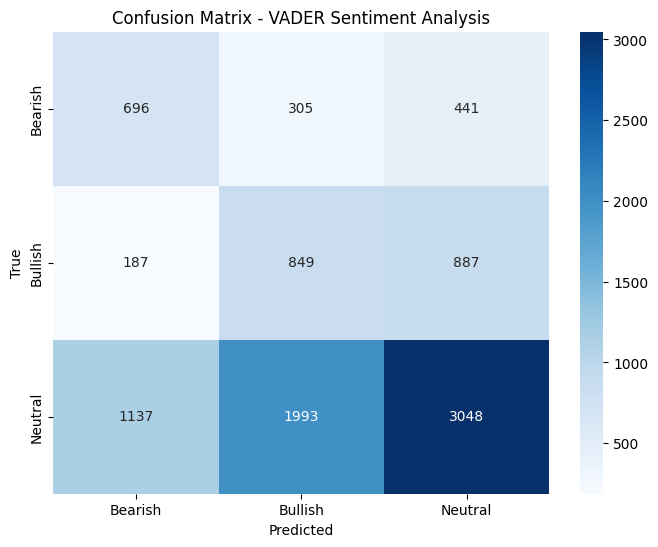

In [ ]:
# Confusion matrix for VADER

import matplotlib.pyplot as plt
# Create confusion matrix
cm_vader = confusion_matrix(true_labels_mapped, vader_sentiments)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_vader, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Bearish', 'Bullish', 'Neutral'],
            yticklabels=['Bearish', 'Bullish', 'Neutral'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - VADER Sentiment Analysis')
plt.show()


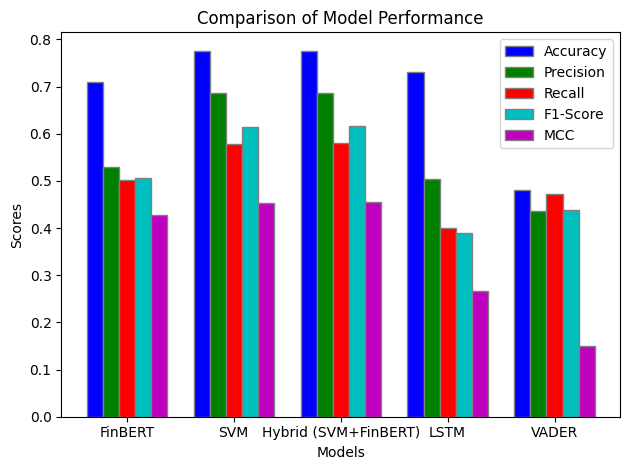

In [ ]:

import matplotlib.pyplot as plt
import numpy as np
# Data for the bar chart
models = ['FinBERT', 'SVM', 'Hybrid (SVM+FinBERT)', 'LSTM', 'VADER']
accuracy_scores = [accuracy_bert, accuracy_svm, accuracy_hybrid, accuracy_lstm, accuracy_vader]
precision_scores = [precision_bert, precision_svm, precision_hybrid, precision_lstm, precision_vader]
recall_scores = [recall_bert, recall_svm, recall_hybrid, recall_lstm, recall_vader]
f1_scores = [f1_bert, f1_svm, f1_hybrid, f1_lstm, f1_vader]
mcc_scores = [mcc_bert, mcc_svm, mcc_hybrid, mcc_lstm, mcc_vader]

# Set the width of the bars
bar_width = 0.15

# Set the positions of the bars on the x-axis
r1 = np.arange(len(models))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]
r4 = [x + bar_width for x in r3]
r5 = [x + bar_width for x in r4]

# Create the bar chart
plt.bar(r1, accuracy_scores, color='b', width=bar_width, edgecolor='grey', label='Accuracy')
plt.bar(r2, precision_scores, color='g', width=bar_width, edgecolor='grey', label='Precision')
plt.bar(r3, recall_scores, color='r', width=bar_width, edgecolor='grey', label='Recall')
plt.bar(r4, f1_scores, color='c', width=bar_width, edgecolor='grey', label='F1-Score')
plt.bar(r5, mcc_scores, color='m', width=bar_width, edgecolor='grey', label='MCC')

# Add labels, title, and legend
plt.xlabel('Models')
plt.ylabel('Scores')
plt.title('Comparison of Model Performance')
plt.xticks([r + bar_width*2 for r in range(len(models))], models)
plt.legend()

# Display the chart
plt.tight_layout()
plt.show()
